# Image Captioning Project

## Inference using trained model

---
Now, we can used our trained model to make inference on <span style="color:red">**unseen**</span> data:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append(r'C:\Users\Project\Documents\Python Scripts\Github_Clone\cocoapi-master\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

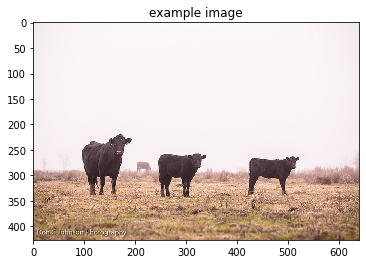

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [3]:
orig_image.shape

torch.Size([1, 427, 640, 3])

In [4]:
image.shape

torch.Size([1, 3, 224, 224])

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

### Load our training model from pickle files

In [7]:
import os
import torch
from model import EncoderCNN, DecoderRNN

# Specify the saved models to load.
encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 1048

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

C:\Users\Project\Anaconda3\envs\Sylar_CV\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


DecoderRNN(
  (embed): Embedding(11497, 256)
  (lstm): LSTM(256, 1048, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4)
  (fc): Linear(in_features=1048, out_features=11497, bias=True)
)

<a id='step3'></a>
## Step 3: push data to the GPU

In [8]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 3278, 13, 1656, 135, 39, 3, 1359, 123, 205, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1]


In [10]:
features.shape

torch.Size([1, 1, 256])

In [11]:
len(output)

25

<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [12]:
def clean_sentence(output):
    sampled_caption = []
    for word_id in output:
        word = data_loader.dataset.vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [13]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: <start> a herd of cattle grazing on a lush green field . <end>


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [14]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

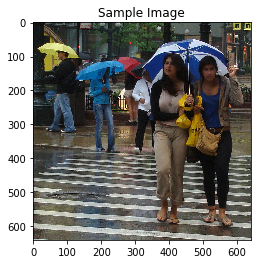

<start> a group of people walking down a street holding umbrellas . <end>


In [25]:
get_prediction()

# Model Evaluation
This is the most basic model we can come up with to do image-captioning.
The model is a quite simple, but it has the right architecture to produce reasonable description.
#### Next up
we will see cases where the model performed well and cases where our model failed.
From the failures, we shall summaries the type of mistakes our model make and propose potential remedies.

### The model performed well!

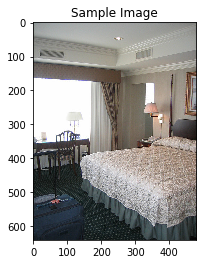

<start> a bed with a white comforter sitting next to a window . <end>


In [36]:
get_prediction()

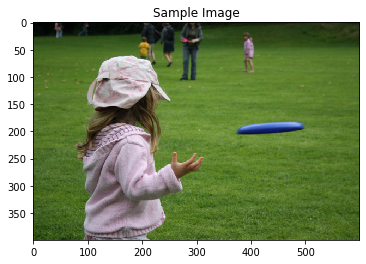

<start> a little girl in a field with a frisbee . <end>


In [40]:
get_prediction()

### The model could have performed better ...

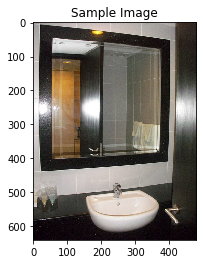

<start> a bathroom with a sink , toilet and a mirror . <end>


In [34]:
get_prediction()

**Remark:** There is <span style="color:green">sink</span> and <span style="color:green">mirror</span>, but there is no <span style="color:red">**toilet**</span>! 
What is potentially happening here is that: in our training images, *toilet* usually appear together with *sinks* and *mirrors*. So our **DecoderRNN** has learnt to assiciate "bathroom pixel features" with all of those since they often come up together in the training captions.
This is not surprising to see, in that we build a **"seq-to-seq"** model where our **DecoderRNN** only gets one input(encoded image feature). In the following time-steps, our decoder only depend on predicted words from previous output(prediction from last time-step). Thus, if the word <span style="color:red">**toilet**</span> appeared together with <span style="color:green">sink</span> and <span style="color:green">mirror</span> in training dataset, the words are likely to come up together in predictions.

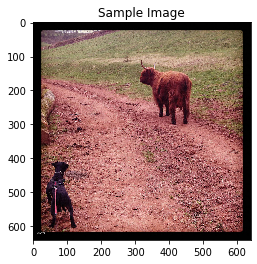

<start> a man is standing in the dirt with a horse . <end>


In [45]:
get_prediction()

**Remark:** There is neither <span style="color:red">man</span> nor <span style="color:red">horse</span> in the picture but a <span style="color:green">dog</span> and a <span style="color:green">cattle</span>. Definitely wrong species!

We could argue that the figure of the <span style="color:green">dog</span> reasonably resembles a <span style="color:red">human</span> figure and the  <span style="color:green">cattle</span> is not very different from a <span style="color:red">horse</span>(surely more furry). This mistake might have to do with how the model has learnt to associate the **objects** in the image with the **backgrounds**. It could be the ***likelihood*** of <span style="color:red">human</span> and <span style="color:red">horse</span> appearing in dirt and grass is bigger than that of a <span style="color:green">dog</span> and a <span style="color:green">cattle</span>. 

# How can we do better?

Dwelling on the mistakes we usually make, besides the limited training tuning we have done, I would say that it has a lot to do with how we constructed our model. More specifically, our **Decoder** gets the image encoder as the input at the *first time-step*. Afterwards, all predictions depend on the predicted word in the last time-step.

This is not very ideal for two main reasons:

1. Decoder only gets to see the input image at first time-step. It would be a lot more intuitive if the encoder gets to **make each word prediction while referring back to different part of the image**. (This would avoid “seeing” a dog and say it’s a human, I expect) In addition, if each word’s prediction could associate back to some part of the image, we should expect less decency among words themselves.
2. The sequence of words that our model predicts has a lot to do with our **first word selection**. Namely, if the model were to choose a terrible first word, it would be unlikely that it perform great captioning afterwards.

To remedy these problems, we are going to implement more sophisticated model with **Attention Mechanism**, and **Beam Search** during decoding in order to boost our performance.

The implementations of the model are shown in my other GitHub repo.
## See you there